In [1]:
from aquacrop.utils import get_filepath, prepare_weather
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm
import yaml

from evaluator import AquaCropEvaluator
from prescriptor import RNNPrescriptorFactory

In [2]:
weather_path = get_filepath("champion_climate.txt")
wdf = prepare_weather(weather_path)

In [3]:
wdf["Date"].min(), wdf["Date"].max()

(Timestamp('1982-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [4]:
nn = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 5)
)
sum(p.numel() for p in nn.parameters())

645

In [5]:
rnn = torch.nn.RNN(4, 64, batch_first=True)
inp = torch.ones(3, 10, 4)

out, h = rnn(inp)
print(out.shape, h.shape)
print(out[0, -1, :])
print(h[0, 0, :])

torch.Size([3, 10, 64]) torch.Size([1, 3, 64])
tensor([-0.4647, -0.2987,  0.1287,  0.2580,  0.0886, -0.1152, -0.0082,  0.2894,
        -0.1069,  0.0154,  0.3121,  0.0136,  0.1245, -0.3011,  0.4942, -0.1926,
        -0.0177,  0.2736,  0.2367,  0.2130,  0.1346,  0.2566,  0.2249,  0.2436,
        -0.3498,  0.2542,  0.1199,  0.2499, -0.4614,  0.0201, -0.5791, -0.0133,
         0.2044, -0.2326, -0.2426, -0.0687,  0.3411,  0.1532, -0.1030, -0.1572,
        -0.0592, -0.0987, -0.0538,  0.2227, -0.2711,  0.3156, -0.0764, -0.0771,
        -0.3993,  0.0140, -0.3659, -0.0670,  0.1842, -0.2272,  0.0023,  0.1512,
         0.1745, -0.2470, -0.2406, -0.2221,  0.2159, -0.1464,  0.0866, -0.1601],
       grad_fn=<SliceBackward0>)
tensor([-0.4647, -0.2987,  0.1287,  0.2580,  0.0886, -0.1152, -0.0082,  0.2894,
        -0.1069,  0.0154,  0.3121,  0.0136,  0.1245, -0.3011,  0.4942, -0.1926,
        -0.0177,  0.2736,  0.2367,  0.2130,  0.1346,  0.2566,  0.2249,  0.2436,
        -0.3498,  0.2542,  0.1199,  0.2

## Examine Results of Experiment

In [34]:
results_df = pd.read_csv("results/potato/results.csv")
baseline_df = pd.read_csv("baselines/one-season.csv")
results_df[results_df["gen"] == results_df["gen"].max()]

,gen,cand_id,parents,cv,rank,distance,yield,irrigation,mulch_pct
9900,100,20_40,"['0_1', '17_32']",0,1,inf,-6.921123,0.000000,99.477661
9901,100,88_28,"['80_31', '80_9']",0,1,inf,-12.292194,549.320393,0.413219
9902,100,75_83,"['70_28', '73_79']",0,1,inf,-12.292194,558.190616,0.702638
9903,100,94_33,"['90_46', '90_46']",0,1,inf,-5.601041,0.000000,0.446643
9904,100,97_54,"['88_28', '92_61']",0,1,inf,-12.292194,571.600729,0.468455
...,...,...,...,...,...,...,...,...,...
9995,100,98_42,"['93_87', '96_79']",0,1,0.035832,-12.241943,365.985914,50.628067
9996,100,99_10,"['87_99', '95_8']",0,1,0.035763,-12.108416,340.157375,29.194221
9997,100,99_37,"['91_94', '96_90']",0,1,0.035694,-10.351439,243.750000,20.107460
9998,100,96_63,"['87_81', '82_96']",0,1,0.035465,-10.713410,218.750000,54.887486


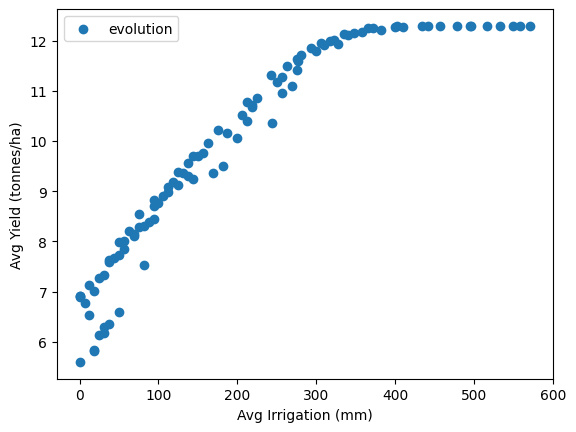

In [35]:
gen_df = results_df[results_df["gen"] == results_df["gen"].max()]
plt.scatter(gen_df["irrigation"], -1 * gen_df["yield"], label="evolution")
# plt.scatter(baseline_df["irrigation"], baseline_df["yield"], color='red', label="baseline")
plt.legend()
plt.xlabel("Avg Irrigation (mm)")
plt.ylabel("Avg Yield (tonnes/ha)")
plt.show()

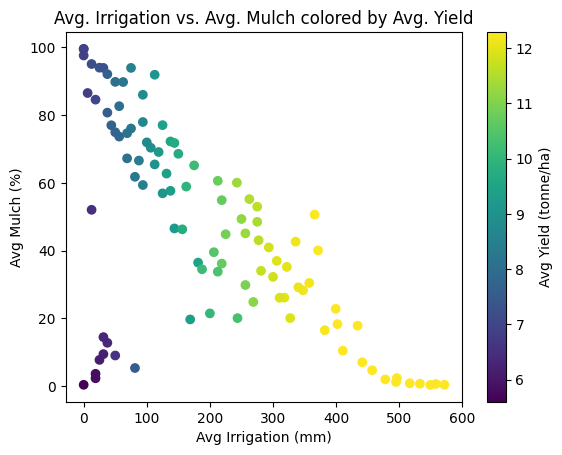

In [36]:
plt.scatter(gen_df["irrigation"], gen_df["mulch_pct"], c=-1 * gen_df["yield"])
plt.title("Avg. Irrigation vs. Avg. Mulch colored by Avg. Yield")
plt.xlabel("Avg Irrigation (mm)")
plt.ylabel("Avg Mulch (%)")
plt.colorbar(label="Avg Yield (tonne/ha)")
plt.show()

In [37]:
dominant_cands = []
for _, row in gen_df.iterrows():
    for _, baseline_row in baseline_df.iterrows():
        if row["irrigation"] < baseline_row["irrigation"] and -1 * row["yield"] > baseline_row["yield"]:
            dominant_cands.append(row["cand_id"])
            break
print(dominant_cands)

[]


## Examine Baseline Results

[0.0, 0.0, 23.77499999999999, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2250000000000227, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 23.77499999999999, 0

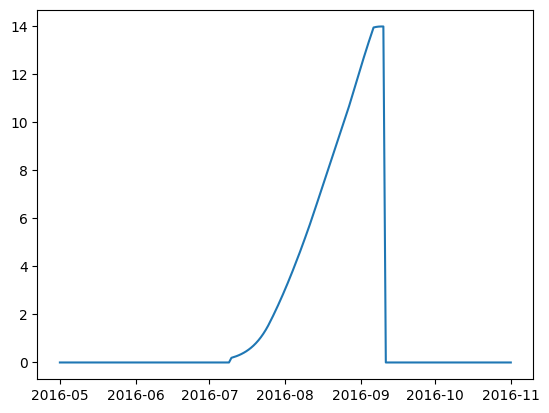

In [10]:
baseline = 5
data_df = pd.read_csv("data/one-season-data.csv", parse_dates=["Date"])
baseline_data = data_df[data_df["baseline"] == baseline]

baseline_data = baseline_data.fillna(0)

print(baseline_data["depth"].tolist())
print(baseline_data["IrrDay"].tolist())

plt.plot(baseline_data["Date"], baseline_data["DryYield"])
plt.show()

## Examining the Results of Runs

In [ ]:
with open("config.yml", "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)
config["n_jobs"] = 1

evaluator = AquaCropEvaluator(**config["eval_params"])
factory = RNNPrescriptorFactory()

population = factory.load_population("results/potato/population")
cand_ids = gen_df["cand_id"].tolist()
results_dfs = {}
for cand_id in tqdm(cand_ids):
    cand = population[cand_id]
    results_dfs[cand_id] = evaluator.run_candidate(cand)

100%|██████████| 100/100 [00:52<00:00,  1.89it/s]


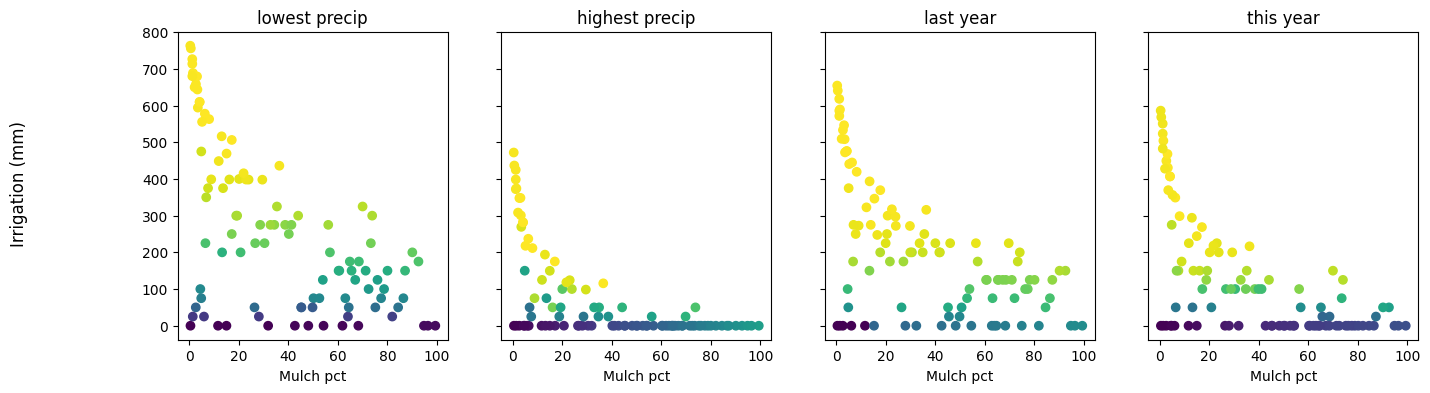

In [20]:
yields = np.zeros((len(cand_ids), 4))
irrs = np.zeros((len(cand_ids), 4))
mulches = np.zeros((len(cand_ids), 4))
for i, (cand_id, results_df) in enumerate(results_dfs.items()):
    for j in range(4):
        yields[i, j] = results_df.iloc[j]["yield"]
        irrs[i, j] = results_df.iloc[j]["irrigation"]
        mulches[i, j] = results_df.iloc[j]["mulch_pct"]

labels = ["lowest precip", "highest precip", "last year", "this year"]
fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
for j in range(4):
    axes[j].scatter(mulches[:, j], irrs[:, j], c=yields[:, j])
    axes[j].set_xlabel("Mulch pct")
    axes[j].set_title(labels[j])
fig.supylabel("Irrigation (mm)")
plt.show()

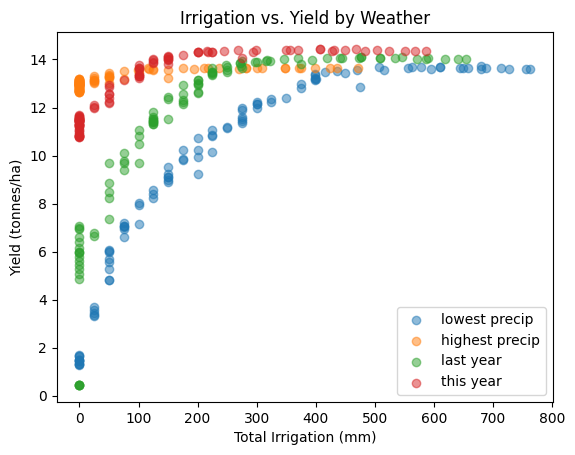

In [25]:
fig, ax = plt.subplots()
for j in range(4):
    ax.scatter(irrs[:, j], yields[:, j], label=labels[j], alpha=0.5)
ax.set_title("Irrigation vs. Yield by Weather")
ax.set_xlabel("Total Irrigation (mm)")
ax.set_ylabel("Yield (tonnes/ha)")
ax.legend()
plt.show()

In [ ]:
wdf = evaluator.weather_data
print(wdf.columns)
filtered = wdf[(wdf["Date"] >= pd.to_datetime(evaluator.sim_start_date)) & (wdf["Date"] <= pd.to_datetime(evaluator.sim_end_date))]
print(len(filtered))
print(len(results_df))

Index(['MinTemp', 'MaxTemp', 'Precipitation', 'ReferenceET', 'Date', 'year'], dtype='object')


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 05/01, at position 0

In [ ]:
assert results_df["depths"].equals(results_df["IrrDay"])
assert results_df["DryYield"].max() == final_stats["Dry yield (tonne/ha)"].max()

KeyError: 'depths'

Bad pipe message: %s [b'\xc3\xafI\xe0\x1a\xc2E\xc3\xfb .\xc6^\x0f\xe0\xc4\x8e3\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00', b"\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x00\xbf\x00\xc0\x00\xc1\x00\xc2\x00\xc3\x00\xc4\x00\xc5\x13\x01\x13\x02\x13\x03\x13\x04\x13\x05\xc0\x01\xc0\x02\xc0\x03\xc0\x04\xc0\x05\xc0\x06\xc0\x07\xc0\x08\xc0\t\xc0\n\xc0\x0b\xc0\x0c\xc0\r\xc0\x0e\xc0\x0f\xc0\x10\xc0\x11\xc0\x12\xc0\x13\xc0\x14\xc0\x15\xc0\x16\xc0\x17\xc0\x18\xc0\x19\xc0#\xc0$\xc0%\xc0&\

In [ ]:
print(results_df.columns)

Index(['time_step_counter', 'season_counter', 'dap', 'Wr', 'z_gw',
       'surface_storage', 'IrrDay', 'Infl', 'Runoff', 'DeepPerc', 'CR', 'GwIn',
       'Es', 'EsPot', 'Tr', 'TrPot', 'growing_season', 'th1', 'th2', 'th3',
       'th4', 'th5', 'th6', 'th7', 'th8', 'th9', 'th10', 'th11', 'th12', 'gdd',
       'gdd_cum', 'z_root', 'canopy_cover', 'canopy_cover_ns', 'biomass',
       'biomass_ns', 'harvest_index', 'harvest_index_adj', 'DryYield',
       'FreshYield', 'YieldPot', 'depths'],
      dtype='object')


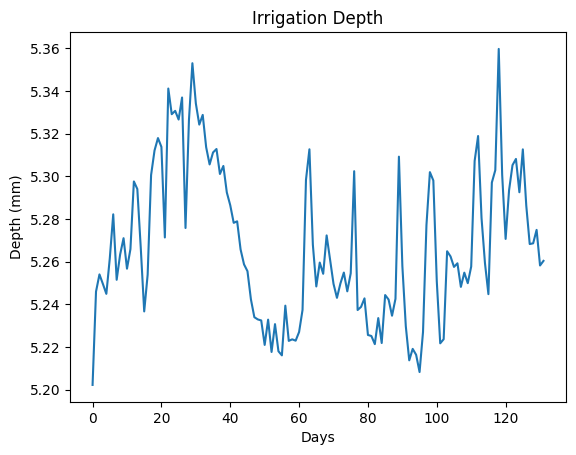

In [ ]:
plt.plot(results_df[results_df["depths"] > 0]["depths"])
plt.title("Irrigation Depth")
plt.xlabel("Days")
plt.ylabel("Depth (mm)")
plt.show()

## Examine Generated Data

In [ ]:
data_df = pd.read_csv("data/one-season-data.csv")
# Filter out rows where every single column except "baseline" is zero
data_df = data_df[(data_df.drop(columns=["baseline"]) != 0).any(axis=1)]

,time_step_counter,season_counter,dap,Wr,z_gw,surface_storage,IrrDay,Infl,Runoff,DeepPerc,...,canopy_cover_ns,biomass,biomass_ns,harvest_index,harvest_index_adj,DryYield,FreshYield,YieldPot,depth,baseline
count,1320.000000,1320.0,1320.000000,1320.000000,0.0,1320.0,1320.000000,1320.000000,1320.000000,1320.0,...,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.000000,1320.0,1320.00000
mean,65.500000,0.0,66.500000,501.664053,NaN,0.0,3.094382,4.763679,0.151309,0.0,...,0.659010,1250.953420,1293.398215,0.112674,0.113235,2.917637,3.241819,2.977852,0.0,4.50000
std,38.118466,0.0,38.118466,201.656147,NaN,0.0,7.981397,8.564819,0.819931,0.0,...,0.374831,1053.667195,1075.570280,0.159682,0.160479,4.476193,4.973547,4.557583,0.0,2.87337
min,0.000000,0.0,1.000000,92.300000,NaN,0.0,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000
25%,32.750000,0.0,33.750000,361.117500,NaN,0.0,0.000000,0.000000,0.000000,0.0,...,0.279066,105.757828,125.067351,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.00000
50%,65.500000,0.0,66.500000,516.345000,NaN,0.0,0.000000,0.000000,0.000000,0.0,...,0.895882,1158.417781,1212.070003,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,4.50000
75%,98.250000,0.0,99.250000,663.532500,NaN,0.0,0.000000,4.570000,0.000000,0.0,...,0.957346,2242.442179,2303.965577,0.214510,0.216138,4.895428,5.439364,4.942393,0.0,7.00000
max,131.000000,0.0,132.000000,858.280000,NaN,0.0,25.000000,34.749199,9.939454,0.0,...,0.958826,2984.223853,2993.138404,0.480000,0.484851,14.451491,16.057213,14.367064,0.0,9.00000
